**Import CIFAR-10 dataset**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 10

    def __init__(self, root, imb_type='exp', imb_factor=0.01, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

In [2]:
def create_sampled_CIFAR10_data():

    transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    trainset = IMBALANCECIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = IMBALANCECIFAR10(root='./data', train=False, download=True, transform=transform_val, imb_factor=1)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)    
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    return trainset, trainloader, testset, testloader

In [3]:
trainset, trainloader, testset, testloader = create_sampled_CIFAR10_data()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


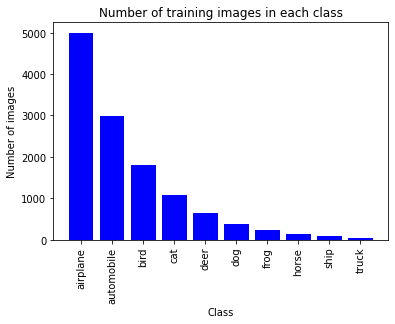

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x_labels = trainset.classes
x = [i for i,_ in enumerate(x_labels)]
y = []

labels = np.array(trainset.targets)
for cls in range(len(x_labels)):
  y.append(len(np.where(labels == cls)[0]))

plt.bar(x,y,color='blue')
plt.xticks(x, x_labels, rotation=90)
plt.ylabel('Number of images')
plt.xlabel('Class')
plt.title('Number of training images in each class')
plt.show()

**Creating ResNet model**

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional

In [6]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    '''
    Implementation is taken from the PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    '''

    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    '''
    Implementation is taken from the PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    '''    
    
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [7]:
class BasicBlock(nn.Module):
    '''
    Implementation is taken from the PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    '''
    
    expansion: int = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1, downsample: Optional[nn.Module] = None, groups: int = 1, base_width: int = 64, dilation: int = 1, norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(BasicBlock, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [8]:
class Bottleneck(nn.Module):
    '''
    Implementation is taken from the PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    '''

    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(self, inplanes: int, planes: int, stride: int = 1, downsample: Optional[nn.Module] = None, groups: int = 1, base_width: int = 64, dilation: int = 1, norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(Bottleneck, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        width = int(planes * (base_width / 64.)) * groups
        
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [9]:
class ResNet(nn.Module):
    '''
    Implementation is taken from the PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    '''


    def __init__(self, block: Type[Union[BasicBlock, Bottleneck]], layers: List[int], num_classes: int = 1000, zero_init_residual: bool = False, groups: int = 1, width_per_group: int = 64, replace_stride_with_dilation: Optional[List[bool]] = None, norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(ResNet, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        self.groups = groups
        self.base_width = width_per_group
        
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        
        if dilate:
            self.dilation *= stride
            stride = 1
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        
        self.inplanes = planes * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)


    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


In [10]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2], 10)

In [119]:
import copy

def train_congestion_avoider_10_classes(device, model, trainloader, criterion, optimizer, cls_num, epoch_counts, boolean_values, grads, total_grads):

  model.train()
  start_time = time.time()

  confusion_matrix = np.zeros((cls_num, cls_num))

  for epoch_count, boolean in zip(epoch_counts, boolean_values):
      if boolean:
          epoch_count = 0
  
  #input, target = next(iter(trainloader))
  #for inputs, targets in zip([input], [target]):
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,targets)
    masks = [targets == k for k in range(cls_num)]
    '''
    for mask in masks:
      print(mask)
    
    # TESTING
    for cls, mask in enumerate(masks):
        print('Class: ', cls)
        print(loss[mask].sum())
    '''
    #sub_losses = [loss[mask].sum() if str(mask.size()) != 'torch.Size([0])' else 0  for mask in masks]
    sub_losses = [loss[mask].sum() for mask in masks]
    
    for name,param in model.named_parameters():
        param.grad = None

    for cls, sub_loss in enumerate(sub_losses):
      sub_loss.backward(retain_graph=True)
      for name,param in model.named_parameters():
        if name in grads[cls].keys():
          grads[cls][name] += torch.mul(copy.deepcopy(param.grad), optimizer.param_groups[0]['lr'])
        else:
          grads[cls][name] = torch.mul(copy.deepcopy(param.grad), optimizer.param_groups[0]['lr'])
        param.grad=None
    
    optimizer.zero_grad()
    loss.sum().backward()
    
    # TESTING
    for name,param in model.named_parameters():
        if name in total_grads.keys():
          total_grads[name] += torch.mul(copy.deepcopy(param.grad), optimizer.param_groups[0]['lr'])
        else:
          total_grads[name] = torch.mul(copy.deepcopy(param.grad), optimizer.param_groups[0]['lr'])
    
    optimizer.step()

    _, predicted = outputs.max(1)

    for target, pred in zip(targets, predicted):
        confusion_matrix[target][pred] += 1

  recalls = np.zeros((cls_num))
  precisions = np.zeros((cls_num))
  fScores = np.zeros((cls_num))

  epoch_counts = [x+1 for x in epoch_counts]

  for cls in range(cls_num):
      if confusion_matrix.sum(1)[cls] != 0:
          recalls[cls] = confusion_matrix[cls][cls] / confusion_matrix.sum(1)[cls]
      else:
          recalls[cls] = 0
      if confusion_matrix.sum(0)[cls] != 0:
          precisions[cls] = confusion_matrix[cls][cls] / confusion_matrix.sum(0)[cls]
      else:
          precisions[cls] = 0
      if (precisions[cls] + recalls[cls]) != 0:
          fScores[cls] = 2 * precisions[cls] * recalls[cls] / (precisions[cls] + recalls[cls])
      else:
          fScores[cls] = 0

  accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

  return confusion_matrix, accuracy, recalls, precisions, fScores, grads, epoch_counts, total_grads
  #return grads, total_grads

In [96]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
import time
import torch.backends.cudnn as cudnn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet18()
model = model.to(device)
if device == 'cuda':
    print('CUDA device used...')
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

lr = 0.1

criterion= torch.nn.CrossEntropyLoss(reduction='none')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=5e-4)
scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=lr, step_size_up=10, mode="triangular2")
cls_num = len(trainset.classes)
epoch_counts = [0]*cls_num
boolean_values = [False]*cls_num
grads = {}
for cls in range(cls_num):
  grads[cls] = {}
total_grads = {}

grads, total_grads = train_congestion_avoider_10_classes(device, model, trainloader, criterion, optimizer, cls_num, epoch_counts, boolean_values, grads, total_grads)

CUDA device used...
Class:  0
tensor(130.3939, device='cuda:0', grad_fn=<SumBackward0>)
Class:  1
tensor(69.7581, device='cuda:0', grad_fn=<SumBackward0>)
Class:  2
tensor(49.1850, device='cuda:0', grad_fn=<SumBackward0>)
Class:  3
tensor(23.2388, device='cuda:0', grad_fn=<SumBackward0>)
Class:  4
tensor(17.6372, device='cuda:0', grad_fn=<SumBackward0>)
Class:  5
tensor(3.5935, device='cuda:0', grad_fn=<SumBackward0>)
Class:  6
tensor(17.4698, device='cuda:0', grad_fn=<SumBackward0>)
Class:  7
tensor(10.1191, device='cuda:0', grad_fn=<SumBackward0>)
Class:  8
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
Class:  9
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)


In [97]:
total_sum = 0
partial_sum = 0
for key, value in total_grads.items():
  total_sum += torch.sum(value)

for cls in grads.keys():
  for key, value in grads[cls].items():
    partial_sum += torch.sum(value)

print(total_sum)
print(partial_sum)

tensor(0.7152, device='cuda:0')
tensor(0.7152, device='cuda:0')


In [27]:
def linear_cong_condition(min_cond, max_cond, epoch, max_epochs):

    condition = min_cond + (max_cond - min_cond) * (epoch / max_epochs)

    return condition

In [28]:
def congestion_avoid_10classes(cls_num, model, optimizer, metrics, condition, grads, min_epochs, mult, epoch_counts, boolean_values, num_class_avg, min_gradient):

    # Create a threshold which is the average metric from a number of the worst performing classes
    threshold = np.average(np.sort(metrics)[:num_class_avg])

    total_grad = {'layer1': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'layer2': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'layer3': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'layer4': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'conv1': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'bn1': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'fc': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0}
                  }

    print('TOTAL GRAIDENTS:')

    for cls in range(cls_num):
        for name, value in model.named_parameters():
            if 'layer1' in str(name):
                total_grad['layer1'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['layer1']['total'] += float(abs(grads[cls][name]).sum())
            elif 'layer2' in str(name):
                total_grad['layer2'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['layer2']['total'] += float(abs(grads[cls][name]).sum())
            elif 'layer3' in str(name):
                total_grad['layer3'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['layer3']['total'] += float(abs(grads[cls][name]).sum())
            elif 'layer4' in str(name):
                total_grad['layer4'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['layer4']['total'] += float(abs(grads[cls][name]).sum())
            elif 'conv1' in str(name):
                total_grad['conv1'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['conv1']['total'] += float(abs(grads[cls][name]).sum())
            elif 'bn1' in str(name):
                total_grad['bn1'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['bn1']['total'] += float(abs(grads[cls][name]).sum())
            elif 'fc' in str(name):
                total_grad['fc'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['fc']['total'] += float(abs(grads[cls][name]).sum())
    print(total_grad)

    for cls in range(cls_num):
        metric = metrics[cls]
        # If the metric of this class is sufficiently above the average of the worst classes
        # And the gradient of that layer is not significant compared to the other classes
        # then the knowledge from that class is returned
        if (threshold < condition * metric) and (epoch_counts[cls] >= min_epochs):
            boolean_values[cls] = True
            print('Condition has been met (class {}) ..... {:.2f}% --> {:.2f}%'.format(cls,100.*threshold, 100.*metric))
            for name, value in model.named_parameters():
                with torch.no_grad():
                  # ADDED CONDITION TO ONLY CHANGE GRADIENTS FROM LAYER 3 ONWARDS
                    if name in grads[cls].keys():# and (('layer4' in str(name)) or ('fc' in str(name))):
                        if ('layer1' in str(name)) and (total_grad['layer1'][cls] < min_gradient * total_grad['layer1']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('layer2' in str(name)) and (total_grad['layer2'][cls] < min_gradient * total_grad['layer2']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('layer3' in str(name)) and (total_grad['layer3'][cls] < min_gradient * total_grad['layer3']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('layer4' in str(name)) and (total_grad['layer4'][cls] < min_gradient * total_grad['layer4']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('conv1' in str(name)) and (not any(layer in str(name) for layer in ('layer1','layer2','layer3','layer4'))) and (total_grad['conv1'][cls] < min_gradient * total_grad['conv1']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('bn1' in str(name)) and (not any(layer in str(name) for layer in ('layer1','layer2','layer3','layer4'))) and (total_grad['bn1'][cls] < min_gradient * total_grad['bn1']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('fc' in str(name)) and (not any(layer in str(name) for layer in ('layer1','layer2','layer3','layer4'))) and (total_grad['fc'][cls] < min_gradient * total_grad['fc']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        else:
                            print('Gradient too significant: ', name)
                            pass
            epoch_counts[cls] = 0
    
        else:
            print('Condition not met (class {}) ..... {:.2f}% --> {:.2f}%'.format(cls,100.*threshold, 100.*metric))

    return optimizer, model, boolean_values, epoch_counts, grads

In [32]:
def test_congestion_avoider_10classes(cls_num, start_time, testloader, device, model, optimizer, scheduler, grads, criterion, epoch, max_epochs, min_cond, max_cond, min_epochs, mult, epoch_counts, num_class_avg, min_gradient):

    ''' 
        XXXX
    '''

    import copy

    print('Classes in test function: ', cls_num)

    model.eval()
    confusion_matrix = np.zeros((cls_num, cls_num))
    recalls = np.zeros((cls_num))
    precisions = np.zeros((cls_num))
    fScores = np.zeros((cls_num))
    boolean_values = np.zeros((cls_num))
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
        
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            _, predicted = outputs.max(1)

            for target, pred in zip(targets, predicted):
                confusion_matrix[target][pred] += 1
    
        for cls in range(cls_num):
            if confusion_matrix.sum(1)[cls] != 0:
                recalls[cls] = confusion_matrix[cls][cls] / confusion_matrix.sum(1)[cls]
            else:
                recalls[cls] = 0
            if confusion_matrix.sum(0)[cls] != 0:
                precisions[cls] = confusion_matrix[cls][cls] / confusion_matrix.sum(0)[cls]
            else:
                precisions[cls] = 0
            if (precisions[cls] + recalls[cls]) != 0:
                fScores[cls] = 2 * precisions[cls] * recalls[cls] / (precisions[cls] + recalls[cls])
            else:
                fScores[cls] = 0

        accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()
        
        #print('recall: ', list(recalls))
        #print('precision: ', list(precisions))
        #print('f-score: ', list(fScores))

        condition = linear_cong_condition(min_cond, max_cond, epoch, max_epochs)
        
        optimizer, model, boolean_values, epoch_counts, grads = congestion_avoid_10classes(cls_num, model, optimizer, fScores, condition, grads, min_epochs, mult, epoch_counts, boolean_values, num_class_avg, min_gradient)
        scheduler.step()

    print('time: %.3f sec'% ((time.time()-start_time)))
    print('Rows: Actual, Columns: Predicted')
    print(confusion_matrix)
    for cls in range(cls_num):
        print('Class %d A: : %.3f%% (%d/%d)'%(cls, 100*accuracy, np.trace(confusion_matrix), confusion_matrix.sum()))
        print('Class %d P: : %.3f%% (%d/%d)'%(cls, 100*precisions[cls], confusion_matrix[cls][cls], confusion_matrix.sum(0)[cls]))
        print('Class %d R: : %.3f%% (%d/%d)'%(cls, 100*recalls[cls], confusion_matrix[cls][cls], confusion_matrix.sum(1)[cls]))
        print('Class %d F: : %.3f%%'%(cls, 100*fScores[cls]))
        print('********************')


    return optimizer, accuracy, precisions, recalls, fScores, boolean_values, grads, epoch_counts

In [115]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
import time
import torch.backends.cudnn as cudnn

def get_cong_avoidance_results_10classes(epochs=100, min_cond=0.95, max_cond = 0.99, mult=1, lr=0.1, min_epochs = 5, num_class_avg = 8, min_gradient =0):

    '''Allow the congestion condition to change linearly over time '''

    # Create ResNet model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ResNet18()
    model = model.to(device)
    if device == 'cuda':
        print('CUDA device used...')
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    # Import data
    trainset, trainloader, testset, testloader = create_sampled_CIFAR10_data()

    # Create variables
    cls_num = len(trainset.classes)
    boolean_values = [False]*cls_num
    grads = {}
    for cls in range(cls_num):
        grads[cls] = {}
    total_grads = {}
    epoch_counts = [0]*cls_num
    
    criterion= nn.CrossEntropyLoss(reduction='none')
    # CREATE MODEL OPTIMIZER
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=5e-4)
    scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=lr, step_size_up=10, mode="triangular2")

    # BEGIN RECORDING THE TIME
    start_time = time.time()

    # Create matrices to store results

    train_acc = np.zeros((epochs, 1))
    train_P = np.zeros((epochs, cls_num))
    train_R = np.zeros((epochs, cls_num))
    train_F = np.zeros((epochs, cls_num))
    test_acc = np.zeros((epochs, 1))
    test_P = np.zeros((epochs, cls_num))
    test_R = np.zeros((epochs, cls_num))
    test_F = np.zeros((epochs, cls_num))
    cong_events = np.zeros((epochs, cls_num))

    for epoch in range(epochs):
        print('\n********** EPOCH {} **********'.format(epoch + 1))
        print('Learning rate: ', optimizer.param_groups[0]['lr'])
        print('Epoch counts: ', epoch_counts)
        confusion_matrix, accuracy, recalls, precisions, fScores, grads, epoch_counts, total_grads = train_congestion_avoider_10_classes(device, model, trainloader, criterion, optimizer, cls_num, epoch_counts, boolean_values, grads, total_grads)
        train_acc[epoch] = accuracy
        train_P[epoch] = precisions
        train_R[epoch] = recalls
        train_F[epoch] = fScores
        optimizer, accuracy, precisions, recalls, fScores, boolean_values, grads, epoch_counts = test_congestion_avoider_10classes(cls_num, start_time, testloader, device, model, optimizer, scheduler, grads, criterion, epoch, epochs, min_cond, max_cond, min_epochs, mult, epoch_counts, num_class_avg, min_gradient)
        test_acc[epoch] = accuracy
        test_P[epoch] = precisions
        test_R[epoch] = recalls
        test_F[epoch] = fScores
        cong_events[epoch] = boolean_values

    total_sum = 0
    partial_sum = 0
    for key, value in total_grads.items():
      total_sum += torch.sum(value)

    for cls in grads.keys():
      for key, value in grads[cls].items():
        partial_sum += torch.sum(value)

    print('Total grad sum: ', total_sum)
    print('Partial grad sum: ', partial_sum)

    return train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events

In [120]:
train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events = get_cong_avoidance_results_10classes(epochs=1, min_cond=0, max_cond = 0, mult=0, lr=0.1, min_epochs = 10, num_class_avg=8, min_gradient=1)

CUDA device used...
Files already downloaded and verified
Files already downloaded and verified

********** EPOCH 1 **********
Learning rate:  0.0001
Epoch counts:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Classes in test function:  10
TOTAL GRAIDENTS:
{'layer1': {0: 58.39572785422206, 1: 67.72831790521741, 2: 42.68140362482518, 3: 38.747429149225354, 4: 28.032729778438807, 5: 23.96245966805145, 6: 17.863307694904506, 7: 15.360634131822735, 8: 11.351349273696542, 9: 10.135592850623652, 'total': 314.2589519310277}, 'layer2': {0: 133.80098816007376, 1: 147.95718090608716, 2: 102.5844729039818, 3: 92.22390989027917, 4: 66.77845894359052, 5: 53.385496627539396, 6: 39.4931521397084, 7: 32.921902724541724, 8: 25.18108956515789, 9: 22.3191991741769, 'total': 716.6458510351367}, 'layer3': {0: 304.27348009869456, 1: 327.44173084944487, 2: 259.60368038341403, 3: 223.90906077809632, 4: 167.598289526999, 5: 125.26075563952327, 6: 95.21832521632314, 7: 66.49596961028874, 8: 51.333015910349786, 9: 44.23263506

In [ ]:
import pickle

with open('CIFAR10_LongTail_1000Test.pickle', 'wb') as file:
    pickle.dump(train_acc, file)
    pickle.dump(train_P, file)
    pickle.dump(train_R, file)
    pickle.dump(train_F, file)
    pickle.dump(test_acc, file)
    pickle.dump(test_P, file)
    pickle.dump(test_R, file)
    pickle.dump(test_F, file)
    pickle.dump(cong_events, file)

In [ ]:
train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events = get_cong_avoidance_results_10classes(epochs=100, min_cond=0.8, max_cond = 0.8, mult=0.5, lr=0.1, min_epochs = 10, num_class_avg=5, min_gradient=1)

In [ ]:
import pickle

with open('cond800_fScore_mult050_min10epochs_avg5class_max1grad.pickle', 'wb') as file:
    pickle.dump(train_acc, file)
    pickle.dump(train_P, file)
    pickle.dump(train_R, file)
    pickle.dump(train_F, file)
    pickle.dump(test_acc, file)
    pickle.dump(test_P, file)
    pickle.dump(test_R, file)
    pickle.dump(test_F, file)
    pickle.dump(cong_events, file)

In [ ]:
train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events = get_cong_avoidance_results_10classes(epochs=100, min_cond=0.5, max_cond = 0.5, mult=0.1, lr=0.1, min_epochs = 10, num_class_avg=8, min_gradient=1)

CUDA device used...
Files already downloaded and verified
Files already downloaded and verified

********** EPOCH 1 **********
Learning rate:  0.0001
Epoch counts:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Classes in test function:  10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


Streaming output truncated to the last 5000 lines.
Class 5 R: : 0.000% (0/1000)
Class 5 F: : 0.000%
********************
Class 6 A: : 18.830% (1883/10000)
Class 6 P: : 0.000% (0/0)
Class 6 R: : 0.000% (0/1000)
Class 6 F: : 0.000%
********************
Class 7 A: : 18.830% (1883/10000)
Class 7 P: : 0.000% (0/0)
Class 7 R: : 0.000% (0/1000)
Class 7 F: : 0.000%
********************
Class 8 A: : 18.830% (1883/10000)
Class 8 P: : 0.000% (0/0)
Class 8 R: : 0.000% (0/1000)
Class 8 F: : 0.000%
********************
Class 9 A: : 18.830% (1883/10000)
Class 9 P: : 0.000% (0/0)
Class 9 R: : 0.000% (0/1000)
Class 9 F: : 0.000%
********************

********** EPOCH 38 **********
Learning rate:  0.01508499999999999
Epoch counts:  [6, 7, 3, 13, 37, 37, 37, 37, 37, 37]
Classes in test function:  10
TOTAL GRAIDENTS:
{'layer1': {0: 1801.9546630382538, 1: 18974.36542892456, 2: 9142.131956100464, 3: 5690.008466720581, 4: 4399.414984703064, 5: 6934.472839355469, 6: 1876.5917506217957, 7: 3422.333884239197, 8

In [ ]:
with open('cond500_fScore_mult010_min10epochs_avg8class_max1grad.pickle', 'wb') as file:
    pickle.dump(train_acc, file)
    pickle.dump(train_P, file)
    pickle.dump(train_R, file)
    pickle.dump(train_F, file)
    pickle.dump(test_acc, file)
    pickle.dump(test_P, file)
    pickle.dump(test_R, file)
    pickle.dump(test_F, file)
    pickle.dump(cong_events, file)

Now only updating weights in layer 4 and the fully connected layer

In [ ]:
def congestion_avoid_10classes_minGradThreshold_v2(cls_num, model, optimizer, metrics, condition, grads, min_epochs, mult, epoch_counts, boolean_values, num_class_avg, min_gradient):

    # Create a threshold which is the average metric from a number of the worst performing classes
    threshold = np.average(np.sort(metrics)[:num_class_avg])

    total_grad = {'layer1': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'layer2': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'layer3': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'layer4': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'conv1': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'bn1': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0},
                  'fc': {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 'total':0}
                  }

    print('TOTAL GRAIDENTS:')

    for cls in range(cls_num):
        for name, value in model.named_parameters():
            if 'layer1' in str(name):
                total_grad['layer1'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['layer1']['total'] += float(abs(grads[cls][name]).sum())
            elif 'layer2' in str(name):
                total_grad['layer2'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['layer2']['total'] += float(abs(grads[cls][name]).sum())
            elif 'layer3' in str(name):
                total_grad['layer3'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['layer3']['total'] += float(abs(grads[cls][name]).sum())
            elif 'layer4' in str(name):
                total_grad['layer4'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['layer4']['total'] += float(abs(grads[cls][name]).sum())
            elif 'conv1' in str(name):
                total_grad['conv1'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['conv1']['total'] += float(abs(grads[cls][name]).sum())
            elif 'bn1' in str(name):
                total_grad['bn1'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['bn1']['total'] += float(abs(grads[cls][name]).sum())
            elif 'fc' in str(name):
                total_grad['fc'][cls] += float(abs(grads[cls][name]).sum())
                total_grad['fc']['total'] += float(abs(grads[cls][name]).sum())
    print(total_grad)

    for cls in range(cls_num):
        metric = metrics[cls]
        # If the metric of this class is sufficiently above the average of the worst classes
        # And the gradient of that layer is not significant compared to the other classes
        # then the knowledge from that class is returned
        if (threshold < condition * metric) and (epoch_counts[cls] >= min_epochs):
            boolean_values[cls] = True
            print('Condition has been met (class {}) ..... {:.2f}% --> {:.2f}%'.format(cls,100.*threshold, 100.*metric))
            for name, value in model.named_parameters():
                with torch.no_grad():
                  # ADDED CONDITION TO ONLY CHANGE GRADIENTS FROM LAYER 3 ONWARDS
                    if name in grads[cls].keys() and (('layer4' in str(name)) or ('fc' in str(name))):
                        if ('layer1' in str(name)) and (total_grad['layer1'][cls] < min_gradient * total_grad['layer1']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('layer2' in str(name)) and (total_grad['layer2'][cls] < min_gradient * total_grad['layer2']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('layer3' in str(name)) and (total_grad['layer3'][cls] < min_gradient * total_grad['layer3']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('layer4' in str(name)) and (total_grad['layer4'][cls] < min_gradient * total_grad['layer4']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('conv1' in str(name)) and (not any(layer in str(name) for layer in ('layer1','layer2','layer3','layer4'))) and (total_grad['conv1'][cls] < min_gradient * total_grad['conv1']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('bn1' in str(name)) and (not any(layer in str(name) for layer in ('layer1','layer2','layer3','layer4'))) and (total_grad['bn1'][cls] < min_gradient * total_grad['bn1']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        elif ('fc' in str(name)) and (not any(layer in str(name) for layer in ('layer1','layer2','layer3','layer4'))) and (total_grad['fc'][cls] < min_gradient * total_grad['fc']['total']):
                            value += mult * grads[cls][name]
                            grads[cls][name] -= mult * grads[cls][name]
                            #print('Gradient used: ', name)
                        else:
                            print('Gradient too significant: ', name)
                            pass
            epoch_counts[cls] = 0
    
        else:
            print('Condition not met (class {}) ..... {:.2f}% --> {:.2f}%'.format(cls,100.*threshold, 100.*metric))

    return optimizer, model, boolean_values, epoch_counts, grads

In [ ]:
train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events = get_cong_avoidance_results_10classes(epochs=100, min_cond=0.5, max_cond = 0.5, mult=0.1, lr=0.1, min_epochs = 10, num_class_avg=8, min_gradient=1)

CUDA device used...
Files already downloaded and verified
Files already downloaded and verified

********** EPOCH 1 **********
Learning rate:  0.0001
Epoch counts:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Classes in test function:  10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


TOTAL GRAIDENTS:
{'layer1': {0: 0.9896240297239274, 1: 0.6461503885511775, 2: 1.7126984756905586, 3: 0.35201447931467555, 4: 1.3115420329850167, 5: 4.103795507457107, 6: 0.16275751357898116, 7: 0.527134401119838, 8: 0.11717803142164485, 9: 0.19273862560658017, 'total': 10.115633485449507}, 'layer2': {0: 2.0579444877803326, 1: 1.2702185600355733, 2: 3.1335810078307986, 3: 0.6861420375789749, 4: 2.3115258587058634, 5: 7.2795784783083946, 6: 0.30239601957873674, 7: 0.9285189531947253, 8: 0.21137072356577846, 9: 0.34956584718747763, 'total': 18.530841973766655}, 'layer3': {0: 4.582260461815167, 1: 2.689633836504072, 2: 5.092800648970297, 3: 1.3639283242227975, 4: 3.6561455700430088, 5: 10.51202758809086, 6: 0.5466800248614163, 7: 1.48721485119313, 8: 0.3755099697991682, 9: 0.6114461047945952, 'total': 30.91764738029451}, 'layer4': {0: 4.631959037098568, 1: 2.747008605976589, 2: 3.242992098123068, 3: 1.2055663167411694, 4: 2.1650734215654666, 5: 3.6472191063221544, 6: 0.42420696575572947, 7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


TOTAL GRAIDENTS:
{'layer1': {0: 86.7109392285347, 1: 61.43516036774963, 2: 243.9599532559514, 3: 42.61663489602506, 4: 131.68148351460695, 5: 1412.3699687421322, 6: 19.600067052058876, 7: 56.34278981667012, 8: 16.18438811530359, 9: 22.069866938516498, 'total': 2092.971251927549}, 'layer2': {0: 186.06038489937782, 1: 131.50170374289155, 2: 415.84532717242837, 3: 84.49273427948356, 4: 233.69588486105204, 5: 2514.4281983673573, 6: 36.848759359214455, 7: 101.7081941794604, 8: 29.116108757909387, 9: 40.26516021043062, 'total': 3773.9624558296055}, 'layer3': {0: 430.19998547434807, 1: 289.0375097785145, 2: 651.2868491709232, 3: 171.7789842132479, 4: 380.2376100458205, 5: 3359.7981376051903, 6: 68.02019671211019, 7: 176.72695265710354, 8: 51.295001067221165, 9: 68.71481660939753, 'total': 5647.096043333877}, 'layer4': {0: 499.7875670865178, 1: 317.5837977975607, 2: 383.2259790673852, 3: 166.36253578215837, 4: 236.2993734292686, 5: 449.7828105762601, 6: 56.76076617697254, 7: 116.86248734220862

In [ ]:
import pickle
with open('cond500_mult010_min10epochs_avg8class_max1grad_layer4onwards.pickle', 'wb') as file:
    pickle.dump(train_acc, file)
    pickle.dump(train_P, file)
    pickle.dump(train_R, file)
    pickle.dump(train_F, file)
    pickle.dump(test_acc, file)
    pickle.dump(test_P, file)
    pickle.dump(test_R, file)
    pickle.dump(test_F, file)
    pickle.dump(cong_events, file)



*   Give back 10% of knowledge on congestion
* Congestion based on average of bottom eight precision values
* Parameter of 50%
* Only return knowledge from a layer if the gradient is less than 20% of the total gradient across all classes for that layer (so is not too significant)



In [ ]:
train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events = get_cong_avoidance_results_10classes(epochs=100, min_cond=0.5, max_cond = 0.5, mult=0.1, lr=0.1, min_epochs = 10, num_class_avg=8, min_gradient=0.2)

In [ ]:
import pickle
with open('cond500_mult010_min10epochs_avg8class_max20grad_layer4onwards.pickle', 'wb') as file:
    pickle.dump(train_acc, file)
    pickle.dump(train_P, file)
    pickle.dump(train_R, file)
    pickle.dump(train_F, file)
    pickle.dump(test_acc, file)
    pickle.dump(test_P, file)
    pickle.dump(test_R, file)
    pickle.dump(test_F, file)
    pickle.dump(cong_events, file)

In [ ]:
train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events = get_cong_avoidance_results_10classes(epochs=100, min_cond=0.5, max_cond = 0.5, mult=0.1, lr=0.1, min_epochs = 10, num_class_avg=8, min_gradient=0.2)

In [ ]:
with open('cond500_mult010_min10epochs_avg8class_max20grad_allLayers.pickle', 'wb') as file:
    pickle.dump(train_acc, file)
    pickle.dump(train_P, file)
    pickle.dump(train_R, file)
    pickle.dump(train_F, file)
    pickle.dump(test_acc, file)
    pickle.dump(test_P, file)
    pickle.dump(test_R, file)
    pickle.dump(test_F, file)
    pickle.dump(cong_events, file)